In [1]:
#Importing essential libraries
from sklearn.datasets import fetch_openml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os 
import cv2
import random 
import math

from datetime import datetime

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow import keras

In [2]:
dfb = pd.read_csv('cic_ids2017_benign.csv')
df1 = pd.read_csv('cic_ids2017_botnet.csv')
df2 = pd.read_csv('cic_ids2017_brute_force.csv')
df3 = pd.read_csv('cic_ids2017_ddos.csv')
df4 = pd.read_csv('cic_ids2017_dos_ddos.csv')
df5 = pd.read_csv('cic_ids2017_infilteration.csv')
df6 = pd.read_csv('cic_ids2017_port_scan.csv')
df7 = pd.read_csv('cic_ids2017_web_attacks.csv')

In [3]:
#Grouping the similar labels 
df2['label']= df2['label'].replace(["FTP-BruteForce","SSH-Bruteforce"],"BruteForce")
df4['label']= df4['label'].replace(["DoS attacks-Hulk","DoS attacks-GoldenEye","DoS attacks-Slowloris","DoS attacks-SlowHTTPTest","Heartbleed"],"DoS")
df7['label']= df7['label'].replace(["Brute Force -Web","Brute Force -XSS","SQL Injection"],"WebAttack")


In [4]:
df = pd.concat([dfb,df1])
del dfb,df1
df = pd.concat([df,df2])
del df2
df = pd.concat([df,df3])
del df3
df = pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7

In [5]:
df['label'].value_counts()

Benign           2273097
DoS               252672
PortScan          158930
DDOS LOIT         128027
BruteForce         13835
WebAttack           2180
Bot                 1966
Infilteration         36
Name: label, dtype: int64

In [6]:
df_shuffled=df.sample(frac=1,random_state=1000)

In [7]:
df_shuffled.head(20)

,dst_port,protocol,timestamp,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,...,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
512415,80,6,5/7/2017 4:57,26701036,6,6,432.0,1774.0,432.0,0.0,...,32,55936.5,2.685945e+04,74929.0,36944.0,10000000.0,9988.590391,10000000.0,9996936.0,Benign
94597,443,6,6/7/2017 2:50,5335290,7,7,350.0,5200.0,200.0,0.0,...,20,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
483398,53,17,5/7/2017 1:21,1195,2,2,80.0,242.0,40.0,40.0,...,32,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
117676,443,6,4/7/2017 11:48,116684477,14,13,1708.0,758.0,533.0,0.0,...,20,144305.5,7.732849e+04,198985.0,89626.0,58200000.0,214077.285100,58300000.0,58000000.0,Benign
394090,53,17,4/7/2017 11:13,171174,2,2,72.0,228.0,36.0,36.0,...,40,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
182985,53,17,7/7/2017 12:14,244,2,2,60.0,344.0,30.0,30.0,...,32,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
303911,80,6,5/7/2017 10:59,68974345,6,6,352.0,11595.0,352.0,0.0,...,32,6.0,0.000000e+00,6.0,6.0,68800000.0,0.000000,68800000.0,68800000.0,DoS
20352,123,17,6/7/2017 9:23,69022364,2,2,96.0,96.0,48.0,48.0,...,32,22308.0,0.000000e+00,22308.0,22308.0,69000000.0,0.000000,69000000.0,69000000.0,Benign
139354,53,17,6/7/2017 3:14,215,2,2,82.0,114.0,41.0,41.0,...,20,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
182139,80,6,5/7/2017 10:50,2,2,0,0.0,0.0,0.0,0.0,...,32,0.0,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,DoS


In [8]:
df_shuffled.shape

(2830743, 80)

In [9]:
df_shuffled=df_shuffled.drop(columns=['timestamp'])

In [10]:
old_memory_usage = df_shuffled.memory_usage().sum()
print("old_memory_usage :",old_memory_usage)
integer = []
f = []
for i in df_shuffled.columns[:-1]:
    if df_shuffled[i].dtype == "int64": integer.append(i)
    else : f.append(i)

df_shuffled[integer] = df_shuffled[integer].astype("int32")
df_shuffled[f] = df_shuffled[f].astype("float32")
new_memory_usage = df_shuffled.memory_usage().sum()
print("new_memory_usage :",new_memory_usage)
old_vs_new = (old_memory_usage - new_memory_usage) / old_memory_usage * 100
print(f"%{old_vs_new} lower memory usage")

old_memory_usage : 1811675520
new_memory_usage : 928483704
%48.75 lower memory usage


In [11]:
# drop one variable features 
one_variable_list = []
for i in df_shuffled.columns:
    if df_shuffled[i].value_counts().nunique() < 2:
        one_variable_list.append(i)
df_shuffled.drop(one_variable_list,axis=1,inplace=True)
df_shuffled.columns =  df_shuffled.columns.str.strip()

In [12]:
df_shuffled = df_shuffled[~df_shuffled.isin([np.nan, np.inf, -np.inf]).any(1)]

In [13]:
df_shuffled =  df_shuffled.drop_duplicates(keep="first")
df_shuffled.reset_index(drop=True,inplace=True)

In [14]:
df_shuffled['label']= pd.Categorical(df_shuffled['label'],['Benign','DoS','PortScan','DDOS LOIT','BruteForce','WebAttack','Bot','Infilteration'])
df_shuffled['label']= df_shuffled['label'].cat.codes

In [15]:
df_shuffled['label'].value_counts()

0    2072444
1     193756
3     128014
2      90694
4       9150
5       2143
6       1948
7         36
Name: label, dtype: int64

In [16]:
train, test=train_test_split(df_shuffled,test_size=0.3, random_state=42)      

In [17]:
print(train.shape)
print(test.shape)
print(train['label'].value_counts())
print(test['label'].value_counts())

(1748729, 71)
(749456, 71)
0    1450255
1     135925
3      89504
2      63763
4       6395
5       1472
6       1388
7         27
Name: label, dtype: int64
0    622189
1     57831
3     38510
2     26931
4      2755
5       671
6       560
7         9
Name: label, dtype: int64


In [18]:
X_train = train.drop(["label"],axis=1)
y_train = train["label"]

In [19]:
print('X_train ',X_train.shape)
print('y_train ',y_train.shape)

X_train  (1748729, 70)
y_train  (1748729,)


In [20]:
digit_train, counts_train = np.unique(y_train, return_counts = True)

distribution_train = dict(zip(digit_train, counts_train))
print(distribution_train)

{0: 1450255, 1: 135925, 2: 63763, 3: 89504, 4: 6395, 5: 1472, 6: 1388, 7: 27}


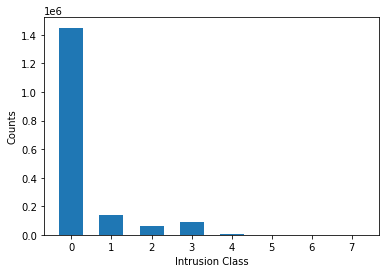

In [21]:
plt.bar(list(distribution_train.keys()),distribution_train.values(),width =0.6)
plt.xlabel('Intrusion Class')
plt.ylabel('Counts')
plt.show()

In [23]:
X_test = test.drop(["label"],axis=1)
y_test = test["label"]
print(X_test.shape, y_test.shape)

(749456, 70) (749456,)


In [24]:
digit_train, counts_train = np.unique(y_test, return_counts = True)

distribution_train = dict(zip(digit_train, counts_train))
print(distribution_train)

{0: 622189, 1: 57831, 2: 26931, 3: 38510, 4: 2755, 5: 671, 6: 560, 7: 9}


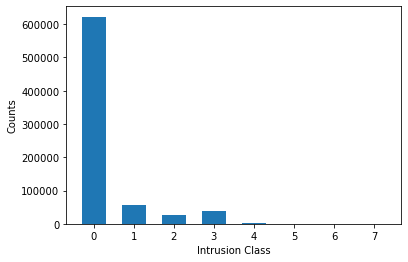

In [25]:
plt.bar(list(distribution_train.keys()),distribution_train.values(),width =0.6)
plt.xlabel('Intrusion Class')
plt.ylabel('Counts')
plt.show()

In [26]:
import pickle

pickle_out = open("X_train_cic.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("y_train_cic.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

In [27]:
pickle_out = open("X_test_cic.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("y_test_cic.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()